In [1]:
%matplotlib inline

import json
import rasa_nlu,rasa_nlu,spacy

In [2]:
from rasa_nlu.evaluate import run_evaluation
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_core.events import SlotSet

In [3]:
abb_expand_md="""

## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent: abbresearch
- I would like to know the abbrevation
- What is the abbrevation for
- abbrevation

## intent: expansion
- I want to know the expansion for
- What is the expansion for
- expansion


"""
%store abb_expand_md > abbexp.md

Writing 'abb_expand_md' (str) to file 'abbexp.md'.


In [4]:
config_c ="""
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config_c > config_c.yml

Writing 'config_c' (str) to file 'config_c.yml'.


In [5]:
train_data= load_data("abbexp.md")

In [6]:
from rasa_nlu import config

# trainer to educate our pipeline
trainer = Trainer(config.load("config_c.yml"))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
interpreter = trainer.train(train_data)
model_directory = trainer.persist("./models/EA", fixed_model_name="current")

Fitting 2 folds for each of 6 candidates, totalling 12 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\c

In [8]:
def output(o):
    print(json.dumps(o,indent=2))
    
output(interpreter.parse("abbrevation"))


{
  "intent": {
    "name": "abbresearch",
    "confidence": 0.6470515815285962
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "abbresearch",
      "confidence": 0.6470515815285962
    },
    {
      "name": "greet",
      "confidence": 0.22180733754907658
    },
    {
      "name": "goodbye",
      "confidence": 0.09917254546469297
    },
    {
      "name": "expansion",
      "confidence": 0.03196853545763417
    }
  ],
  "text": "abbrevation"
}


In [9]:
import sqlite3
connection = sqlite3.connect("expand1.db")
cursor = connection.cursor()

cursor.execute("SELECT * FROM ea")
print("fetchall:")
result = cursor.fetchall()
for r in result:
    print(r)

fetchall:
('1NAM ', ' One in a million')
('143', 'I love you')
('1432', ' I love you too')
('2moro ', 'Tomorrow')
('2N8', 'Tonight')
('404', 'No clue')
('4Eva', 'Forever')
('ASAP', 'As soon as possible')


C:\ProgramData\Anaconda3\lib\site-packages\rasa_nlu\extractors\entity_synonyms.py:85: UserWarning: Failed to load synonyms file from 'D:\Jupyter\Text Generation - RNN\Abbrevatin_exp_bot\./models/EA\default\current\entity_synonyms.json'
  "".format(entity_synonyms_file))


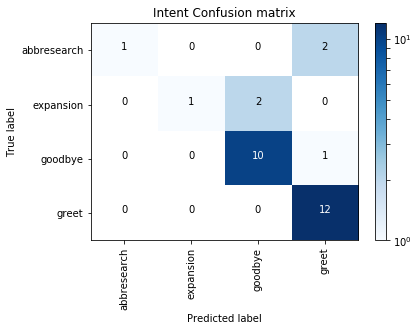

In [10]:
run_evaluation("abbexp.md",model_directory)

In [11]:
story_md ="""

 
## concept path          
* greet
  - utter_greet
* ask_expansion
    -utter_ask_expansion
* inform{"group":"expansion"}
    - action_retrieve_expansion
* ask_abbrevation
  - utter_ask_abrevation
* inform{"group":"abbrevation"}  
  - action_retrieve_expansion
* mood_affirm
  - utter_happy
  
## fallback
- utter_unclear   

  
"""
  
%store story_md >story.md

Writing 'story_md' (str) to file 'story.md'.


In [12]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_great
- inform

slots:
  group:
    type: text
    
entities:
- group

actions:
- utter_greet
- utter_happy
- utter_unclear
- utter_ask_abrevation
- utter_ask_expansion
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_ask_abrevation:
  - text: "Would u like to know the abbrevation for something?"
  
  utter_ask_expansion:
  - text: "Would u like to know the expansion for something?"
  
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


In [13]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

class ApiAction(Action):
    def name(self):
        return "action_retrieve_expansion"
   ## def name(self):
       ## return "action_retrieve_abbrevation"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
          
        q = "SELECT expansion FROM ea WHERE group='{0}'limit 1".format(group)
        result = cursor.execute(q)
        if result:
            return print(cursor.fetchone())
        else:
            return None
    
    
    
    
    ##return [SlotSet("matches", result if result is not None else cursor.fetchone())]
        
        #return [SlotSet("matches", result if result is not None else [])]
    
       


In [ ]:
class ApiAction(Action):
    def name(self):
        return "action_retrieve_expansion"
   ## def name(self):
       ## return "action_retrieve_abbrevation"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
          
        q = "SELECT expansion FROM ea WHERE group='{0}'limit 1".format(group)
        result = cursor.execute(q)
        if result:
            return print(cursor.fetchone())
        else:
            return None

In [14]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.1)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('story.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/EA')

Using TensorFlow backend.
Processed trackers: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 51.29it/s, # actions=44]
Processed actions: 44it [00:00, 1026.02it/s, # examples=44]
Processed trackers: 100%|████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.35it/s, # actions=44]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5, 15)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 6,408
Trainable params: 6,408
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
44/44 [==============================] - ETA: 0s - loss: 2.1518 - acc: 0.218 - 1s 13ms/step - loss: 2.1333 - acc: 0.1818
Epoch 2/200
44/44 [==============================] - ETA: 0s - loss: 2.0696 - acc: 0.187 - 0s 295us/step - loss: 2.0635 - acc: 0.1818
Epoch

44/44 [==============================] - ETA: 0s - loss: 1.2785 - acc: 0.562 - 0s 317us/step - loss: 1.2496 - acc: 0.5682
Epoch 56/200
44/44 [==============================] - ETA: 0s - loss: 1.1726 - acc: 0.625 - 0s 340us/step - loss: 1.2261 - acc: 0.5682
Epoch 57/200
44/44 [==============================] - ETA: 0s - loss: 1.2347 - acc: 0.562 - 0s 249us/step - loss: 1.2143 - acc: 0.5682
Epoch 58/200
44/44 [==============================] - ETA: 0s - loss: 1.2301 - acc: 0.562 - 0s 249us/step - loss: 1.2247 - acc: 0.5682
Epoch 59/200
44/44 [==============================] - ETA: 0s - loss: 1.1948 - acc: 0.593 - 0s 272us/step - loss: 1.1751 - acc: 0.5682
Epoch 60/200
44/44 [==============================] - ETA: 0s - loss: 1.2507 - acc: 0.531 - 0s 272us/step - loss: 1.1974 - acc: 0.5909
Epoch 61/200
44/44 [==============================] - ETA: 0s - loss: 1.0972 - acc: 0.593 - 0s 295us/step - loss: 1.1531 - acc: 0.5682
Epoch 62/200
44/44 [==============================] - ETA: 0s - loss

44/44 [==============================] - ETA: 0s - loss: 0.7884 - acc: 0.750 - 0s 227us/step - loss: 0.7391 - acc: 0.7955
Epoch 116/200
44/44 [==============================] - ETA: 0s - loss: 0.7164 - acc: 0.781 - 0s 249us/step - loss: 0.7071 - acc: 0.7500
Epoch 117/200
44/44 [==============================] - ETA: 0s - loss: 0.6526 - acc: 0.781 - 0s 272us/step - loss: 0.6850 - acc: 0.8182
Epoch 118/200
44/44 [==============================] - ETA: 0s - loss: 0.5826 - acc: 0.843 - 0s 317us/step - loss: 0.6503 - acc: 0.8182
Epoch 119/200
44/44 [==============================] - ETA: 0s - loss: 0.6446 - acc: 0.843 - 0s 272us/step - loss: 0.6336 - acc: 0.8409
Epoch 120/200
44/44 [==============================] - ETA: 0s - loss: 0.6568 - acc: 0.875 - 0s 295us/step - loss: 0.6489 - acc: 0.8409
Epoch 121/200
44/44 [==============================] - ETA: 0s - loss: 0.6077 - acc: 0.781 - 0s 295us/step - loss: 0.6453 - acc: 0.7955
Epoch 122/200
44/44 [==============================] - ETA: 0s

44/44 [==============================] - ETA: 0s - loss: 0.3637 - acc: 0.906 - 0s 385us/step - loss: 0.3136 - acc: 0.9318
Epoch 176/200
44/44 [==============================] - ETA: 0s - loss: 0.2861 - acc: 0.968 - 0s 340us/step - loss: 0.2498 - acc: 0.9773
Epoch 177/200
44/44 [==============================] - ETA: 0s - loss: 0.2716 - acc: 0.968 - 0s 295us/step - loss: 0.2585 - acc: 0.9773
Epoch 178/200
44/44 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.968 - 0s 295us/step - loss: 0.2573 - acc: 0.9773
Epoch 179/200
44/44 [==============================] - ETA: 0s - loss: 0.2653 - acc: 0.937 - 0s 295us/step - loss: 0.2524 - acc: 0.9545
Epoch 180/200
44/44 [==============================] - ETA: 0s - loss: 0.2122 - acc: 0.968 - 0s 295us/step - loss: 0.2433 - acc: 0.9773
Epoch 181/200
44/44 [==============================] - ETA: 0s - loss: 0.1943 - acc: 1.000 - 0s 317us/step - loss: 0.2585 - acc: 0.9773
Epoch 182/200
44/44 [==============================] - ETA: 0s

In [20]:
from IPython.display import Image
from rasa_core.agent import Agent



agent = Agent('domain.yml')
agent.visualize("story.md","sg.png",max_history=2)
##agent.visualize("story.md", "story_graph.png", max_history=1)
Image(filename="sg.png")

Processed Story Blocks: 100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 668.84it/s, # trackers=1]


OSError: Format: "dot" not recognized. Use one of:


In [16]:
#Starting the Bot

from rasa_core.agent import Agent
agent = Agent.load('models/EA', interpreter=model_directory)

C:\ProgramData\Anaconda3\lib\site-packages\rasa_nlu\extractors\entity_synonyms.py:85: UserWarning: Failed to load synonyms file from 'D:\Jupyter\Text Generation - RNN\Abbrevatin_exp_bot\./models/EA\default\current\entity_synonyms.json'
  "".format(entity_synonyms_file))


In [24]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])

Your bot is ready to talk! Type your messages here or send 'stop'
stop
